# Vectorized multi-state Patch Extraction with `torch.gather`

## The Problem

In **multiplexed ptychography**, we have multiple objects in **multiple states** (e.g., laser ON/OFF). 
Each scan position was acquired under a different state. We need to extract the correct patch from the correct state.

**The slow way (with a loop):**
```python
for i, batch_id in enumerate(batch_indices):
    state = int(states_mask[batch_id])  # ← GPU→CPU sync every iteration!
    patch = obj[state][patch_indices[i]]
```

**The fast way (vectorized):**
```python
channels = states_mask[batch_indices]   # Step 1: lookup
obj_per_batch = obj[channels]           # Step 2: advanced indexing
patches = gather(obj_flat, patch_idx)   # Step 3-4: flatten + gather
```

This notebook explains each step with visualizations.

In [1]:
import torch
import torch.utils.benchmark as benchmark
import matplotlib.pyplot as plt
import numpy as np

def get_device():
    """Get the best available device: CUDA → XPU → MPS → CPU."""
    if torch.cuda.is_available():
        return torch.device('cuda')
    if hasattr(torch, 'xpu') and torch.xpu.is_available():
        return torch.device('xpu')
    if torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

device = get_device()
print(f"Device: {device}")

Device: cuda


## Setup: Create a small example

We create a simple 8×8 object with **2 channels** (states). Both channels have values at ALL pixels,
representing the same sample in different physical states (e.g., laser ON vs OFF):

```text
Channel 0 (laser OFF)              Channel 1 (laser ON)
┌─────┬─────┬─────┬─────┬───┐      ┌─────┬─────┬─────┬─────┬───┐
│ 100 │ 101 │ 102 │ 103 │...│      │ 200 │ 201 │ 202 │ 203 │...│
├─────┼─────┼─────┼─────┼───┤      ├─────┼─────┼─────┼─────┼───┤
│ 108 │ 109 │ 110 │ 111 │...│      │ 208 │ 209 │ 210 │ 211 │...│
├─────┼─────┼─────┼─────┼───┤      ├─────┼─────┼─────┼─────┼───┤
│ ... │     │     │     │   │      │ ... │     │     │     │   │
└─────┴─────┴─────┴─────┴───┘      └─────┴─────┴─────┴─────┴───┘
  values = 100 + pixel_idx           values = 200 + pixel_idx
```

The 100 vs 200 offset makes it easy to verify which channel was extracted.

**How the probe scans (alternating laser state):**

```text
     Laser OFF    Laser ON     Laser OFF    Laser ON
        ↓            ↓            ↓            ↓
      ┌───┐        ┌───┐        ┌───┐        ┌───┐
      │ 0 │───────▶│ 1 │───────▶│ 2 │───────▶│ 3 │───▶ ...
      └───┘        └───┘        └───┘        └───┘
        │            │            │            │
        ▼            ▼            ▼            ▼
    Channel 0    Channel 1    Channel 0    Channel 1

Channel 0 gets data from positions: 0, 2, 4, 6, ...
Channel 1 gets data from positions: 1, 3, 5, 7, ...
```

**This cell prepares the inputs for the forward function:**
- `obj` — the multi-state object (2 channels × 8×8 pixels)
- `patches_mask` — which state each scan position was acquired with (e.g., `[0, 1, 0, 1, ...]`)
- `batch_indices` — which scan positions to process in this batch (4 out of 16)
- `patch_indices` — computed from probe positions using a grid scan pattern

In [2]:
import torch

# Small example for visualization
NUM_CHANNELS = 2        # 2 states: laser OFF (0) and laser ON (1)
NUM_SLICES = 1          # single slice (thin sample)
OBJ_H, OBJ_W = 8, 8     # small 8×8 object for easy visualization
BATCH_SIZE = 4          # 4 scan positions per batch
PATCH_H, PATCH_W = 2, 2 # 2×2 patches

# Create REALISTIC object: both channels have values at ALL pixels
# Channel 0: values = 100 + pixel_index (laser OFF state)
# Channel 1: values = 200 + pixel_index (laser ON state)
obj = torch.zeros(NUM_CHANNELS, NUM_SLICES, OBJ_H, OBJ_W, dtype=torch.complex64)
for i in range(OBJ_H * OBJ_W):
    row, col = i // OBJ_W, i % OBJ_W
    obj[0, 0, row, col] = 100.0 + i  # Channel 0: 100, 101, 102, ...
    obj[1, 0, row, col] = 200.0 + i  # Channel 1: 200, 201, 202, ...

# States mask: alternating pattern (position 0 → state 0, position 1 → state 1, ...)
NUM_SCAN_POSITIONS = 100
patches_mask = torch.tensor([i % 2 for i in range(NUM_SCAN_POSITIONS)])  # [0, 1, 0, 1, ...]
# This batch processes positions 0, 1, 2, 3
batch_indices = torch.tensor([0, 1, 2, 3])

# Generate ALL probe positions for a grid scan
# In real ptychography, these come from the scan pattern
SCAN_STEP = 2  # probe step size in pixels
max_row = OBJ_H - PATCH_H  # valid range: 0 to 6 for 8×8 with 2×2 patch
max_col = OBJ_W - PATCH_W

# Create grid of all valid probe positions
all_probe_positions = []
for r in range(0, max_row + 1, SCAN_STEP):
    for c in range(0, max_col + 1, SCAN_STEP):
        all_probe_positions.append([r, c])
all_probe_positions = torch.tensor(all_probe_positions)

print(f"Total scan positions: {len(all_probe_positions)}")
print(f"Grid: {(max_row // SCAN_STEP) + 1} × {(max_col // SCAN_STEP) + 1}")

# Select probe positions for this batch
probe_positions = all_probe_positions[batch_indices]

# Compute patch_indices from probe positions
def compute_patch_indices(positions, patch_h, patch_w, obj_w):
    """Compute flattened indices for patches at given positions."""
    batch_size = positions.shape[0]
    # Create local offsets for a patch
    row_offsets = torch.arange(patch_h).view(-1, 1).expand(patch_h, patch_w)
    col_offsets = torch.arange(patch_w).view(1, -1).expand(patch_h, patch_w)
    
    # Vectorized computation (no loop!)
    rows = positions[:, 0].view(-1, 1, 1) + row_offsets
    cols = positions[:, 1].view(-1, 1, 1) + col_offsets
    return rows * obj_w + cols

patch_indices = compute_patch_indices(probe_positions, PATCH_H, PATCH_W, OBJ_W)

print()
print("Probe positions (row, col) for this batch:")
for b in range(BATCH_SIZE):
    row, col = probe_positions[b].tolist()
    print(f"  Batch {b}: ({row}, {col}) → patch_indices = {patch_indices[b].flatten().tolist()}")

Total scan positions: 16
Grid: 4 × 4

Probe positions (row, col) for this batch:
  Batch 0: (0, 0) → patch_indices = [0, 1, 8, 9]
  Batch 1: (0, 2) → patch_indices = [2, 3, 10, 11]
  Batch 2: (0, 4) → patch_indices = [4, 5, 12, 13]
  Batch 3: (0, 6) → patch_indices = [6, 7, 14, 15]


## Visualize the two objects

Both channels have values at every pixel (like a real sample). The offset (100 vs 200) makes it easy to identify which channel was extracted:

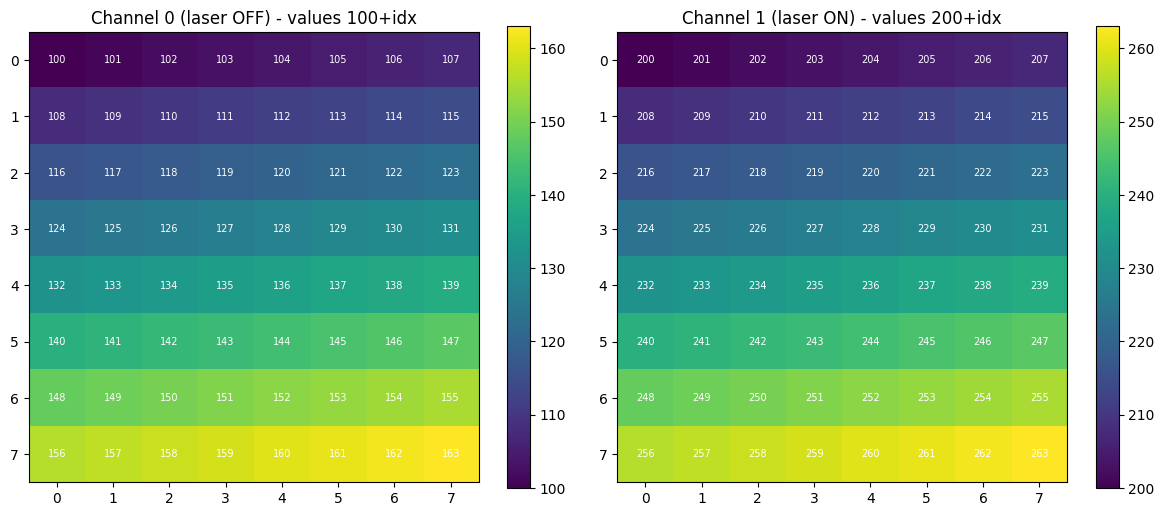

Both channels have values at ALL pixels (like real ptychography).
  Channel 0: 100 + pixel_idx → 100, 101, 102, ..., 163
  Channel 1: 200 + pixel_idx → 200, 201, 202, ..., 263


In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ch in range(2):
    ax = axes[ch]
    data = obj[ch, 0].real.numpy()
    offset = 100 if ch == 0 else 200
    im = ax.imshow(data, cmap='viridis', vmin=offset, vmax=offset + 63)
    ax.set_title(f"Channel {ch} (laser {'OFF' if ch == 0 else 'ON'}) - values {offset}+idx") 
    # Add pixel values as text
    for i in range(OBJ_H):
        for j in range(OBJ_W):
            val = int(data[i, j])
            ax.text(j, i, f"{val}", ha='center', va='center', fontsize=7, color='white')
    
    ax.set_xticks(range(OBJ_W))
    ax.set_yticks(range(OBJ_H))
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
print("Both channels have values at ALL pixels (like real ptychography).")
print("  Channel 0: 100 + pixel_idx → 100, 101, 102, ..., 163")
print("  Channel 1: 200 + pixel_idx → 200, 201, 202, ..., 263")

## Step-by-step: The vectorized forward function

We'll trace through each step with code and visualizations.

### Step 1: Which state was each scan position acquired in?

Each scan position was acquired with the laser either ON or OFF. We need to look up the state for each batch item.

```text
batch_indices = [0, 1, 2, 3]           ← "Which scan positions to process?"
                 ↓  ↓  ↓  ↓
patches_mask  = [0, 1, 0, 1, 0, 1...]  ← "Which state was each position acquired with?"
                 ↓  ↓  ↓  ↓
channels      = [0, 1, 0, 1]           ← Result: state for each batch item
```

In [4]:
# Step 1: Channel lookup via advanced indexing
channels = patches_mask[batch_indices]
channels

tensor([0, 1, 0, 1])

### Step 2: How do we select the correct object for each batch item? (advanced indexing)


```text
obj.shape = (2, 1, 8, 8)    ← 2 channels, each is (1, 8, 8)

obj[0] → Channel 0: shape (1, 8, 8)  # Laser OFF
obj[1] → Channel 1: shape (1, 8, 8)  # Laser ON

channels = [0, 1, 0, 1]

obj[channels] = obj[[0, 1, 0, 1]]
              = stack([obj[0], obj[1], obj[0], obj[1]])
              → shape (4, 1, 8, 8)   ← 4 batch items!

This is equivalent to:  torch.stack([obj[ch] for ch in channels])
But advanced indexing is VECTORIZED → much faster on GPU!
```

In [5]:
# Step 2: Select correct object per batch via advanced indexing
obj_per_batch = obj[channels]
obj_per_batch.shape

torch.Size([4, 1, 8, 8])

### Step 3: How do we prepare data for random-access extraction?

`torch.gather` works on 1D arrays, so we flatten the 2D spatial dimensions:

```text
obj_per_batch: (4, 1, 8, 8)  →  obj_flat: (4, 1, 64)
                    ↑  ↑                        ↑
                   H  W                       H*W

patch_indices: (4, 2, 2)  →  idx_flat: (4, 4)
                  ↑  ↑                    ↑
                 H  W                   H*W
```

In [6]:
# First flatten data for gather
batch_size, num_slices = obj_per_batch.shape[:2]
patch_shape = patch_indices.shape[1:]
obj_flat = obj_per_batch.reshape(batch_size, num_slices, -1)  # (B, S, H*W)
idx_flat = patch_indices.reshape(batch_size, -1)               # (B, patch_h*patch_w)
print(f"obj_flat.shape = {obj_flat.shape}  ← 2D (8×8) flattened to 1D (64)")
print(f"idx_flat.shape = {idx_flat.shape}  ← 2D (2×2) patch indices flattened to 1D (4)")

obj_flat.shape = torch.Size([4, 1, 64])  ← 2D (8×8) flattened to 1D (64)
idx_flat.shape = torch.Size([4, 4])  ← 2D (2×2) patch indices flattened to 1D (4)


### Step 4: How does `torch.gather` extract pixels?

**Example: Extract a 2×2 patch starting at position (0, 0) from Channel 0**

```text
Channel 0 (8×8 object, values = 100 + idx):     Patch indices [0, 1, 8, 9]:
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│100* │101* │ 102 │ 103 │ 104 │ 105 │ 106 │ 107 │   row 0: indices 0, 1
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤         ↓  ↓
│108* │109* │ 110 │ 111 │ 112 │ 113 │ 114 │ 115 │   row 1: indices 8, 9
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ 116 │ 117 │ 118 │ 119 │ 120 │ 121 │ 122 │ 123 │   * = pixels we want
│ ... │     │     │     │     │     │     │     │
└─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┘

Flatten 2D → 1D:
  Index:   0    1    2    3    4    5    6    7    8    9   10   11 ...
        ┌────┬────┬────┬────┬────┬────┬────┬────┬────┬────┬────┬────┬
  Value:│100 │101 │102 │103 │104 │105 │106 │107 │108 │109 │110 │111 │...
        └────┴────┴────┴────┴────┴────┴────┴────┴────┴────┴────┴────┴
          ▲    ▲                            ▲    ▲
          └────┴────────────────────────────┴────┘
                     idx = [0, 1, 8, 9]
                              │
                              ▼
                    gathered = [100, 101, 108, 109]

Reshape back to 2×2:
        ┌─────┬─────┐
        │ 100 │ 101 │
        ├─────┼─────┤
        │ 108 │ 109 │
        └─────┴─────┘
```

**Why do we need shape manipulation?**

`gather` requires index to have the same dimensions as input:

```text
obj_flat.shape = (batch=4, slices=1, pixels=64)
                               ↑
idx_flat.shape = (batch=4,          pixels=4)   ← missing slices!

Fix: idx[:, None, :]  inserts a size-1 dimension
     (4, 4) → (4, 1, 4)  ✓
```

**Why `view_as_real` for complex numbers?**

MPS doesn't support gather on complex tensors, so we split real/imag:

```text
complex64:   (108+0j)  →  view_as_real  →  [108.0, 0.0]
                                            real   imag

obj_flat: (4, 1, 64)         →  obj_real: (4, 1, 64, 2)
idx:      (4, 1, 4)          →  idx_real: (4, 1, 4, 2)
                                                    ↑
                     [:, :, :, None].expand(..., 2) adds this

Same index picks BOTH real and imag parts:
  idx = [0, 1, 8, 9]  →  [[0,0], [1,1], [8,8], [9,9]]
```

In [7]:
# Step 4: Gather pixels at specified indices

# Add slices dimension to match obj_flat shape for gather
# (4, 4)  →  (4, 1, 4) via [:, None, :]
idx = idx_flat[:, None, :].expand(batch_size, num_slices, -1)
print(f"idx_flat.shape = {idx_flat.shape}  →  idx.shape = {idx.shape}")
print(f"obj_flat.shape = {obj_flat.shape}")

# view_as_real: complex64 → float32 with extra dim of size 2
obj_real = torch.view_as_real(obj_flat)  # (B, S, 64) → (B, S, 64, 2)
idx_real = idx[:, :, :, None].expand(-1, -1, -1, 2)  # (B, S, 4) → (B, S, 4, 2)
print(f"\nAfter view_as_real:")
print(f"  obj_real.shape = {obj_real.shape}  ← last dim is [real, imag]")
print(f"  idx_real.shape = {idx_real.shape}  ← same index for real & imag")

# THE GATHER
patches_real = torch.gather(obj_real, dim=2, index=idx_real)
patches_flat = torch.view_as_complex(patches_real.contiguous())
print(f"\nAfter gather:")
print(f"  patches_flat.shape = {patches_flat.shape}  ← {idx_flat.shape[1]} pixels per batch")

idx_flat.shape = torch.Size([4, 4])  →  idx.shape = torch.Size([4, 1, 4])
obj_flat.shape = torch.Size([4, 1, 64])

After view_as_real:
  obj_real.shape = torch.Size([4, 1, 64, 2])  ← last dim is [real, imag]
  idx_real.shape = torch.Size([4, 1, 4, 2])  ← same index for real & imag

After gather:
  patches_flat.shape = torch.Size([4, 1, 4])  ← 4 pixels per batch


### Step 5: How do we reshape the result back to 2D patches?

The gathered pixels are flat. Reshape them back to the original patch dimensions.

```text
patches_flat.shape = (batch_size, num_slices, patch_h * patch_w)
                   = (4, 1, 4)

reshape → (4, 1, 2, 2)
transpose → (1, 4, 2, 2)  ← Final: (num_slices, batch_size, patch_h, patch_w)
```

In [8]:
# Step 5: Reshape back to 2D patches
patches = patches_flat.reshape(batch_size, num_slices, *patch_shape)
patches = patches.transpose(0, 1)  # (B, S, h, w) → (S, B, h, w)

print(f"patches.shape = {patches.shape}  ← (num_slices, batch_size, patch_h, patch_w)")

patches.shape = torch.Size([1, 4, 2, 2])  ← (num_slices, batch_size, patch_h, patch_w)


## Verification: Did we extract correctly?

In [9]:
print("Extracted patches:")
print()
for b in range(BATCH_SIZE):
    ch = channels[b].item()
    patch = patches[0, b].real.numpy()  # slice 0, batch b
    indices = patch_indices[b].numpy().flatten()
    
    print(f"Batch {b} (channel {ch}, position {batch_indices[b].item()}):")
    print(f"  Patch indices: {indices.tolist()}")
    print(f"  Extracted values: {patch.flatten().astype(int).tolist()}")
    
    # With realistic objects:
    # - Channel 0: values = 100 + pixel_idx
    # - Channel 1: values = 200 + pixel_idx
    offset = 100 if ch == 0 else 200
    expected_values = [offset + int(idx) for idx in indices]
    
    print(f"  Expected values:  {expected_values}")
    
    match = all(patch.flatten().astype(int) == expected_values)
    print(f"  Match: {'✓' if match else '✗'}")
    print()

Extracted patches:

Batch 0 (channel 0, position 0):
  Patch indices: [0, 1, 8, 9]
  Extracted values: [100, 101, 108, 109]
  Expected values:  [100, 101, 108, 109]
  Match: ✓

Batch 1 (channel 1, position 1):
  Patch indices: [2, 3, 10, 11]
  Extracted values: [202, 203, 210, 211]
  Expected values:  [202, 203, 210, 211]
  Match: ✓

Batch 2 (channel 0, position 2):
  Patch indices: [4, 5, 12, 13]
  Extracted values: [104, 105, 112, 113]
  Expected values:  [104, 105, 112, 113]
  Match: ✓

Batch 3 (channel 1, position 3):
  Patch indices: [6, 7, 14, 15]
  Extracted values: [206, 207, 214, 215]
  Expected values:  [206, 207, 214, 215]
  Match: ✓



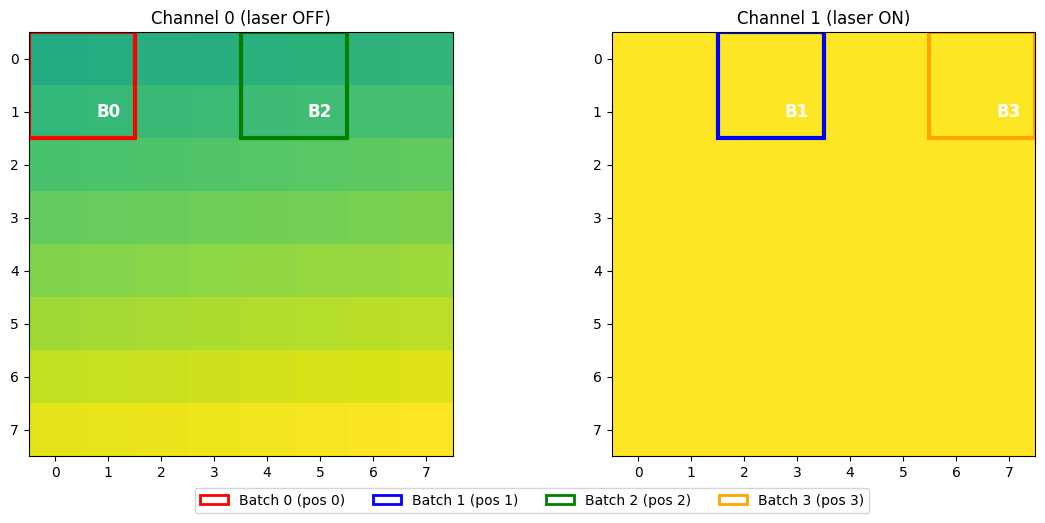

Batches 0, 2 (even positions) → Channel 0 (laser OFF)
Batches 1, 3 (odd positions) → Channel 1 (laser ON)


In [10]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['red', 'blue', 'green', 'orange']

for ch in range(2):
    ax = axes[ch]
    data = obj[ch, 0].real.numpy()
    ax.imshow(data, cmap='viridis', vmin=0, vmax=163)
    ax.set_title(f"Channel {ch} (laser {'OFF' if ch == 0 else 'ON'})")
    
    # Draw boxes for patches that came from this channel
    for b in range(BATCH_SIZE):
        if channels[b].item() == ch:
            # Get the 2D position of this patch
            indices = patch_indices[b].numpy()
            min_idx = indices.min()
            row, col = min_idx // OBJ_W, min_idx % OBJ_W
            
            rect = mpatches.Rectangle((col - 0.5, row - 0.5), PATCH_W, PATCH_H, 
                                      linewidth=3, edgecolor=colors[b], facecolor='none')
            ax.add_patch(rect)
            ax.text(col + PATCH_W/2, row + PATCH_H/2, f"B{b}", 
                   ha='center', va='center', fontsize=12, color='white', fontweight='bold')
    
    ax.set_xticks(range(OBJ_W))
    ax.set_yticks(range(OBJ_H))

# Add legend
legend_elements = [mpatches.Patch(facecolor='none', edgecolor=colors[b], linewidth=2, 
                                  label=f'Batch {b} (pos {batch_indices[b].item()})') 
                   for b in range(BATCH_SIZE)]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

print("Batches 0, 2 (even positions) → Channel 0 (laser OFF)")
print("Batches 1, 3 (odd positions) → Channel 1 (laser ON)")

## The complete forward function

All steps combined into one clean function:

In [11]:
def forward(obj, patch_indices, batch_indices, patches_mask):
    """Extract patches from multi-state object using vectorized gather.
    
    Args:
        obj: (num_channels, num_slices, obj_h, obj_w) - multi-state object
        patch_indices: (batch_size, patch_h, patch_w) - flat indices for each patch
        batch_indices: (batch_size,) - which scan positions in this batch
        patches_mask: (num_positions,) - which channel/state each position uses
    
    Returns:
        (num_slices, batch_size, patch_h, patch_w) - extracted patches
    """
    # Step 1: Channel lookup
    channels = patches_mask[batch_indices].long()
    
    # Step 2: Advanced indexing - select correct channel per batch
    obj_per_batch = obj[channels]
    
    # Step 3: Flatten for gather
    batch_size, num_slices = obj_per_batch.shape[:2]
    patch_shape = patch_indices.shape[1:]
    obj_flat = obj_per_batch.reshape(batch_size, num_slices, -1)
    idx_flat = patch_indices.reshape(batch_size, -1)
    
    # Step 4: Gather with view_as_real for MPS compatibility
    idx = idx_flat[:, None, :].expand(-1, num_slices, -1)
    obj_real = torch.view_as_real(obj_flat)
    idx_real = idx[:, :, :, None].expand(-1, -1, -1, 2)
    patches_real = torch.gather(obj_real, dim=2, index=idx_real)
    patches_flat = torch.view_as_complex(patches_real.contiguous())
    
    # Step 5: Reshape to final output
    patches = patches_flat.reshape(batch_size, num_slices, *patch_shape)
    return patches.transpose(0, 1)

# Test it
result = forward(obj, patch_indices, batch_indices, patches_mask)
print(f"✓ Output shape: {result.shape}")

✓ Output shape: torch.Size([1, 4, 2, 2])


## Benchmark: Loop vs vectorized

Let's measure the speedup with realistic sizes:

In [12]:
import torch.utils.benchmark as benchmark

# Realistic sizes for benchmarking (different from the small visualization example)
BENCH_NUM_CHANNELS = 2
BENCH_NUM_SLICES = 1
BENCH_OBJ_H, BENCH_OBJ_W = 256, 256
BENCH_BATCH_SIZE = 128
BENCH_PATCH_H, BENCH_PATCH_W = 64, 64
BENCH_NUM_POSITIONS = 1000

obj_large = torch.randn(BENCH_NUM_CHANNELS, BENCH_NUM_SLICES, BENCH_OBJ_H, BENCH_OBJ_W, 
                        dtype=torch.complex64, device=device)
patches_mask_large = torch.randint(0, BENCH_NUM_CHANNELS, (BENCH_NUM_POSITIONS,), device=device)
batch_indices_large = torch.randint(0, BENCH_NUM_POSITIONS, (BENCH_BATCH_SIZE,), device=device)
patch_indices_large = torch.randint(0, BENCH_OBJ_H * BENCH_OBJ_W, 
                                    (BENCH_BATCH_SIZE, BENCH_PATCH_H, BENCH_PATCH_W), 
                                    dtype=torch.long, device=device)

print(f"Object: {obj_large.shape}")
print(f"Batch: {BENCH_BATCH_SIZE} items, each patch: {BENCH_PATCH_H}×{BENCH_PATCH_W}")

Object: torch.Size([2, 1, 256, 256])
Batch: 128 items, each patch: 64×64


In [13]:
def _get_obj_patches(obj_array, patch_idx):
    """Helper for loop version."""
    obj_flat = obj_array.reshape(obj_array.shape[0], -1)
    real, imag = obj_flat.real, obj_flat.imag
    return torch.complex(real[:, patch_idx], imag[:, patch_idx])

def forward_loop(obj, patch_indices, batch_indices, patches_mask):
    """Slow: loop with GPU→CPU sync."""
    patch_indices_flat = patch_indices.reshape(patch_indices.shape[0], -1)
    patches = []
    for i, batch_id in enumerate(batch_indices):
        ch = int(patches_mask[batch_id])  # ← GPU→CPU sync!
        patch = _get_obj_patches(obj[ch, ...], patch_indices_flat[i])
        patches.append(patch)
    result = torch.stack(patches, dim=0).transpose(0, 1)
    return result.reshape(result.shape[0], result.shape[1], *patch_indices.shape[1:])

# Benchmark
timer_loop = benchmark.Timer(
    stmt='forward_loop(obj, patch_indices, batch_indices, patches_mask)',
    globals={'forward_loop': forward_loop, 'obj': obj_large, 
             'patch_indices': patch_indices_large, 'batch_indices': batch_indices_large,
             'patches_mask': patches_mask_large}
)
timer_fast = benchmark.Timer(
    stmt='forward(obj, patch_indices, batch_indices, patches_mask)',
    globals={'forward': forward, 'obj': obj_large, 
             'patch_indices': patch_indices_large, 'batch_indices': batch_indices_large,
             'patches_mask': patches_mask_large}
)

result_loop = timer_loop.blocked_autorange(min_run_time=1.0)
result_fast = timer_fast.blocked_autorange(min_run_time=1.0)

t_loop = result_loop.median * 1000
t_fast = result_fast.median * 1000
speedup = t_loop / t_fast

print(f"\nLoop version:       {t_loop:.3f} ms")
print(f"Vectorized version: {t_fast:.3f} ms")
print(f"Speedup:            {speedup:.0f}×")


Loop version:       6.175 ms
Vectorized version: 0.041 ms
Speedup:            149×


## Appendix: How `torch.gather` works

### 1D gather

In [14]:
# 1D gather: select specific elements by index
print("1D Gather Example")
print("=" * 40)
input_1d = torch.tensor([10, 20, 30, 40, 50])
index_1d = torch.tensor([4, 0, 2])

print(f"input = {input_1d.tolist()}")
print(f"index = {index_1d.tolist()}")
print()

result = torch.gather(input_1d, dim=0, index=index_1d)
print(f"gather(input, dim=0, index) = {result.tolist()}")
print()
print("Visual:")
print("  input[4] = 50  ─┐")
print("  input[0] = 10  ─┼──→  [50, 10, 30]")
print("  input[2] = 30  ─┘")

1D Gather Example
input = [10, 20, 30, 40, 50]
index = [4, 0, 2]

gather(input, dim=0, index) = [50, 10, 30]

Visual:
  input[4] = 50  ─┐
  input[0] = 10  ─┼──→  [50, 10, 30]
  input[2] = 30  ─┘


### 2D gather

In [15]:
# 2D gather: select elements along one dimension
print("\n2D Gather Example (dim=1)")
print("=" * 40)
input_2d = torch.arange(12).reshape(3, 4)
index_2d = torch.tensor([[3, 0], [1, 2], [0, 3]])

print("input (3×4):")
print(input_2d)
print()
print("index (3×2):")
print(index_2d)
print()

result_2d = torch.gather(input_2d, dim=1, index=index_2d)
print("result = gather(input, dim=1, index):")
print(result_2d)
print()
print("Explanation:")
print("  Row 0: indices [3, 0] → pick columns 3 and 0 → [3, 0]")
print("  Row 1: indices [1, 2] → pick columns 1 and 2 → [5, 6]")
print("  Row 2: indices [0, 3] → pick columns 0 and 3 → [8, 11]")


2D Gather Example (dim=1)
input (3×4):
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

index (3×2):
tensor([[3, 0],
        [1, 2],
        [0, 3]])

result = gather(input, dim=1, index):
tensor([[ 3,  0],
        [ 5,  6],
        [ 8, 11]])

Explanation:
  Row 0: indices [3, 0] → pick columns 3 and 0 → [3, 0]
  Row 1: indices [1, 2] → pick columns 1 and 2 → [5, 6]
  Row 2: indices [0, 3] → pick columns 0 and 3 → [8, 11]


## Summary

| Step | Question | Code |
|------|----------|------|
| 1 | Which state was each scan position acquired in? | `channels = patches_mask[batch_indices]` |
| 2 | How do we select the correct object for each batch item? | `obj_per_batch = obj[channels]` |
| 3 | How do we prepare data for random-access extraction? | `obj_flat = obj.reshape(B, D, -1)` |
| 4 | How do we extract specific pixels from each object? | `torch.gather(obj_flat, dim=2, index=idx)` |
| 5 | How do we reshape the result back to 2D patches? | `patches.transpose(0, 1)` |

**Key insight**: Everything stays on GPU. No `int()` calls = no sync = fast!